In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from ipywidgets import interactive

Assume have 1D body moving under some known external driving acceleration $a(t)$
$$\vec{x}(t+dt) =
\begin{pmatrix} x(t+dt)\\ v(t+dt) \end{pmatrix} = 
\begin{pmatrix} 1 & dt \\ 0 & 1 \end{pmatrix} \begin{pmatrix} x(t)\\ v(t) \end{pmatrix} +
\begin{pmatrix} dt^2/2 \\ dt \end{pmatrix} a(t) = 
F \vec{x}(t) + Ba(t)$$

Assume that initial position and velocity of the body is uncertain, and is mv-gaussian-distributed
$$\hat{x}(t=0) \sim \mathcal{N}(\vec{\mu}, \Sigma)$$
Then it can be shown that
$$\hat{x}(t) \sim \mathcal{N}(\vec{\mu}_x(t), \Sigma_x(t))$$
where
$$\begin{eqnarray}
  \vec{\mu}_x(t+dt) &=& F\vec{\mu}(t) + Ba(t)\\
  \Sigma_x(t+dt) &=& F\Sigma(t)F^T
\end{eqnarray}$$




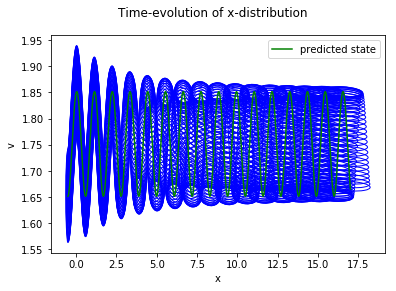

In [2]:
#Example 1.0
def update_mu(mu, F, A, w, t):
    return F.dot(mu) + A * np.sin(w * t)

def update_sig(S, F):
    return F.dot(S.dot(F.T))

# Create a random covariance matrix
def make_random_cov():
    a = np.random.uniform(0, 2*np.pi)
    c,s = np.cos(a), np.sin(a)
    R = np.array([[c, s],[-s, c]])
    D = np.random.uniform(0, 1, 2)
    return R.dot(np.diag(D).dot(R.T))

# Convert covariance matrix to a 1-sigma-ellipse
def cov2ellipse(S):
    e,v = np.linalg.eig(S)
    std = np.sqrt(e)
    idxs = np.flip(np.argsort(std))
    std, v = std[idxs], v[idxs]
    return std[0], std[1], np.arctan2(v[0][1], v[0][0])

# Init
N_STEP = 100000
dt = 0.0001
w = 10                                # Input frequency
F = np.array([[1, dt],[0, 1]])        # State evolution matrix
A = np.array([dt**2/2, dt])           # Input matrix
mu = np.random.uniform(-3, 3, 2)      # Mean
S  = 0.1*make_random_cov()            # Covariance


# Simulate
mu_lst = [mu]
S_lst = [S]
for i in range(N_STEP):
    mu = update_mu(mu, F, A, w, i*dt)
    S = update_sig(S, F)
    mu_lst += [mu]
    S_lst += [S]
    
# Plot
fig, ax = plt.subplots()
fig.suptitle("Time-evolution of x-distribution")
ax.set_xlabel("x")
ax.set_ylabel("v")
for i in range(N_STEP):
    if i % 100  == 0:
        mu, S = mu_lst[i], S_lst[i]
        ax.add_patch(Ellipse(mu, *cov2ellipse(S), edgecolor='b', facecolor='none'))
ax.plot([x[0] for x in mu_lst], [x[1] for x in mu_lst], color='g', label='predicted state')
ax.legend()
ax.autoscale_view()

Ok, now there is a bunch of sensors $\vec{z}$ that measure, in general, some linear combination $\vec{H}$ of our parameters

$$z(t) \sim \mathcal{N}(\vec{\mu}_z, \Sigma_z) \sim \mathcal{N}(H \vec{x}_{true}(t), \Sigma_z)$$

We can also make a prediction of the sensor measurement

$$\hat{z}(t) \sim \mathcal{N}(H\hat{x}(t), H\Sigma_x(t)H^T)$$

We can then improve prediction $\hat{x}(t)$ by constructing posterior distribution

$$P[\hat{x} | sensor] = \frac{P[sensor | \hat{x}]P[\hat{x}]}{\sum P[sensor | \hat{x}]P[\hat{x}]}$$

Thanks to everything being Gaussian, the posterior distribution is

$P[\hat{x} | sensor] \sim \mathcal{N}(\hat{x}', \Sigma_x')$

where

$$\begin{eqnarray}
  \hat{x}' &=& \hat{x} + K'(z - H\hat{x})\\
  \Sigma_x' &=& (\mathbb{1} - K'H) \Sigma_x\\
  K' &=& \Sigma_x H^T (H \Sigma_x H^T + \Sigma_z)^{-1}
\end{eqnarray}$$

So the plan is:
1. Update state estimate $\vec{x}(t), \Sigma_x(t) \rightarrow \vec{x}(t+dt), \Sigma_x(t+dt)$
2. Replace new state estimate with posterior estimate due to sensor info

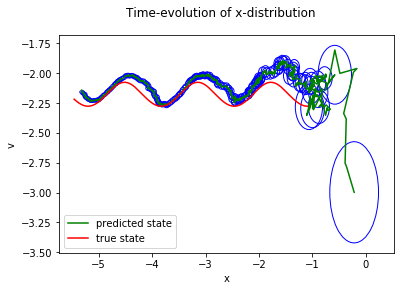

In [7]:
# Bayesian Model Inversion to reconcile state and sensor distributions
def update_kalman(mu_x, S_x, mu_z, S_z):
    K = S_x.dot(H.T.dot(np.linalg.inv(H.dot(S_x.dot(H.T)) + S_z)))
    x1 = mu_x + K.dot(mu_z - H.dot(mu_x))
    S_x1 = S_x - K.dot(H.dot(S_x))
    return x1, S_x1

# Init
N_STEP = 2000
dt = 0.001
w = 10                                # Input frequency
F = np.array([[1, dt],[0, 1]])        # State evolution matrix
A = np.array([dt**2/2, dt])           # Input matrix
x_true = np.random.uniform(-3, 3, 2)  # True initial state
mu_x = np.random.uniform(-3, 3, 2)    # Mean of state estimate
S_x = make_random_cov()               # Covariance of state estimate
S_z = 10*make_random_cov()            # Covariance of sensor estimate
H = np.diag([1, 1])                   # Map from state to sensor

# Simulate
x_true_lst = [x_true]
mu_lst = [mu_x]
S_lst = [S_x]
for i in range(N_STEP):
    x_true = update_mu(x_true, F, A, w, i*dt)          # 1. Update using forwards model
    mu_x = update_mu(mu_x, F, A, w, i*dt)              # 1. Update using forwards model
    S_x  = update_sig(S_x, F)                          # 1. Update using forwards model
    mu_z = np.random.multivariate_normal(x_true, S_z)  # 2. Measure from sensor
    mu_x, S_x = update_kalman(mu_x, S_x, mu_z, S_z)    # 3. Update state estimate using sensor estimate
    mu_lst += [mu_x]
    S_lst += [S_x]
    x_true_lst += [x_true]
    
# Plot
fig, ax = plt.subplots()
fig.suptitle("Time-evolution of x-distribution")
ax.set_xlabel("x")
ax.set_ylabel("v")
for i in range(N_STEP):
    if i % 10 == 0:
        mu, S = mu_lst[i], S_lst[i]
        ax.add_patch(Ellipse(mu, *cov2ellipse(S), edgecolor='b', facecolor='none'))        

ax.plot([x[0] for x in mu_lst], [x[1] for x in mu_lst], color='g', label='predicted state')
ax.plot([x[0] for x in x_true_lst], [x[1] for x in x_true_lst], color='r', label='true state')
ax.legend()
ax.autoscale_view()
plt.show()